In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [38]:
df_or = pd.read_csv('orderbook.csv')

In [39]:
df = df_or

## 1 - Original dataframe

In [40]:
df = df.drop(columns=['Unnamed: 0', 'time', 'type'], axis=1)

In [41]:
df.isnull().sum()

price     0
count     0
amount    0
dtype: int64

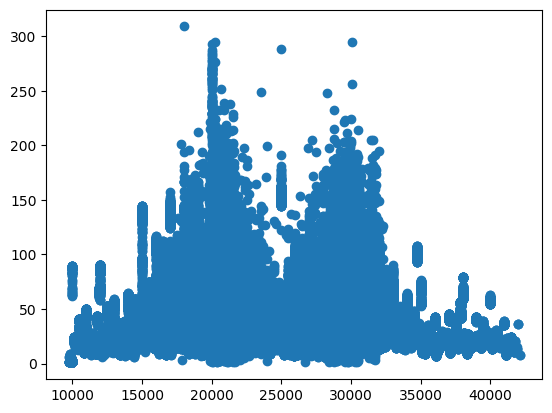

In [42]:
plt.scatter(x=df['price'], y=df['count'])
plt.show()

In [43]:
# remove duplicated rows
df = df.drop_duplicates()

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaler = scaler.fit_transform(df)

dfs = pd.DataFrame(df_scaler, columns=df.columns)
print(dfs)

          price     count    amount
0      0.616811  0.211039  0.537001
1      0.613721  0.285714  0.649742
2      0.610630  0.120130  0.603765
3      0.607540  0.146104  0.539884
4      0.604450  0.123377  0.523882
...         ...       ...       ...
64309  0.372682  0.152597  0.502482
64310  0.375773  0.129870  0.503041
64311  0.378863  0.185065  0.493117
64312  0.397404  0.139610  0.485574
64313  0.403585  0.146104  0.499273

[64314 rows x 3 columns]


### 1.1 - Outlier Detection

In [54]:
eps_values

array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5])

In [56]:
def plot_columns(df, name):
    fig, ax =plt.subplots(1, 2, figsize=(20,10))
    sns.distplot(df[name], ax=ax[0])
    sns.boxplot(df[name], ax=ax[1])
    plt.show()

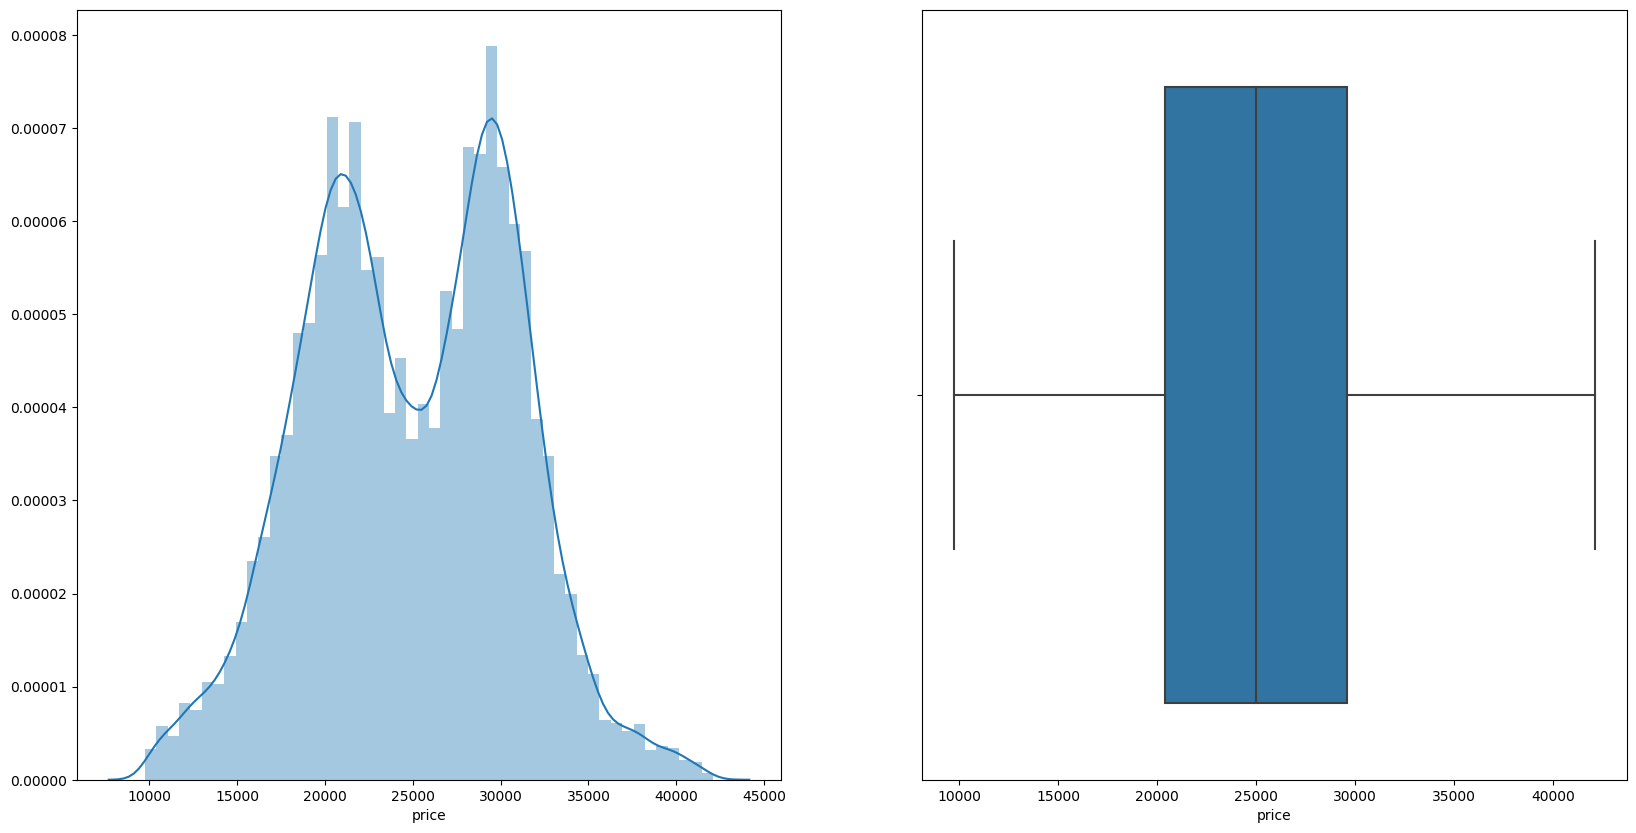

In [57]:
plot_columns(df, 'price')

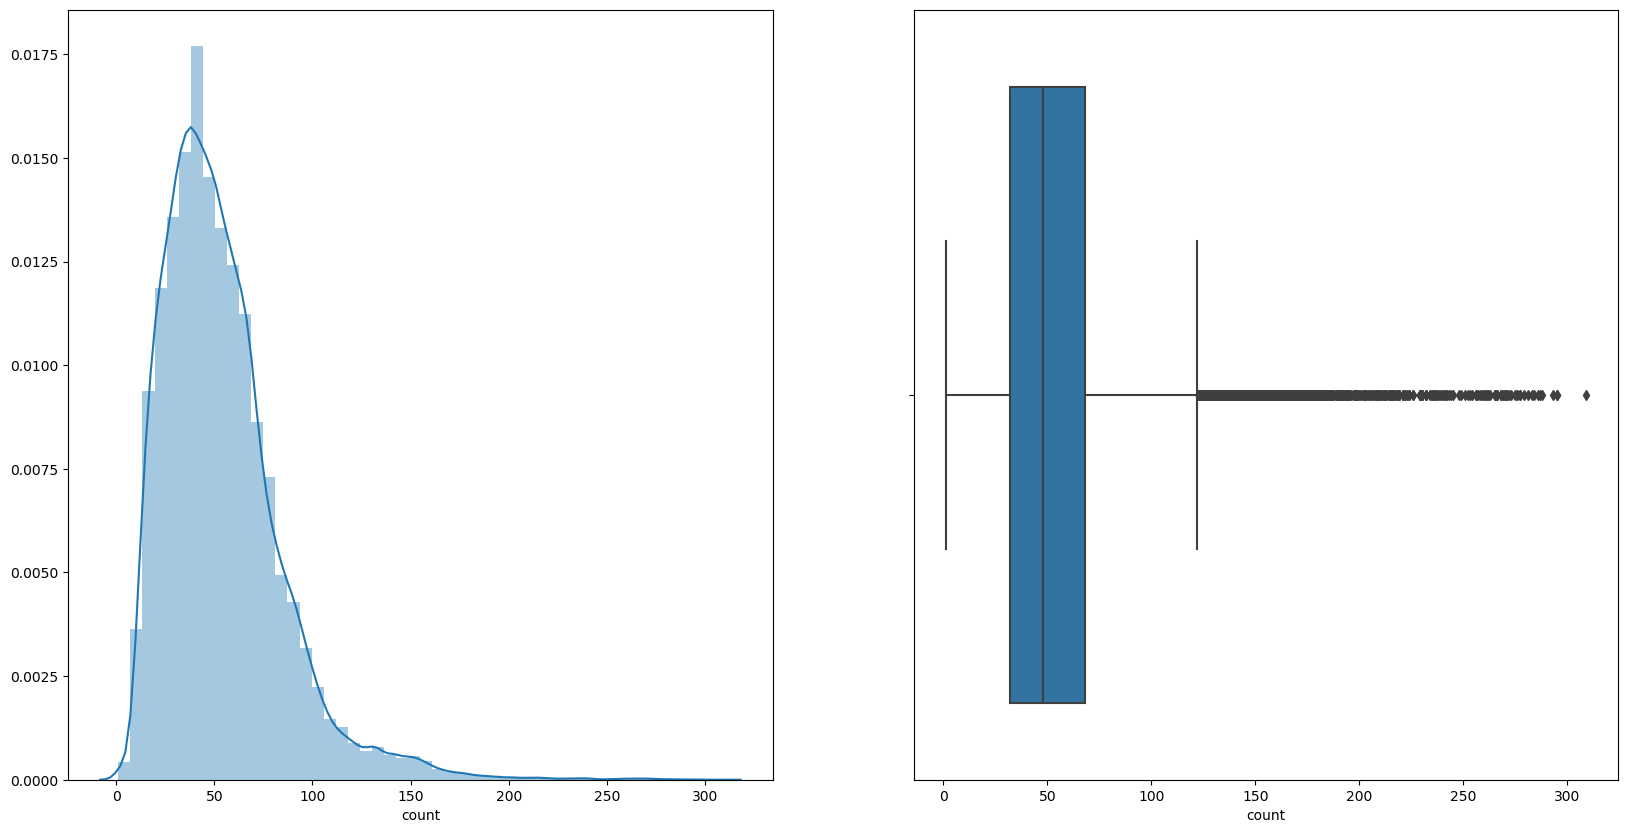

In [58]:
plot_columns(df, 'count')

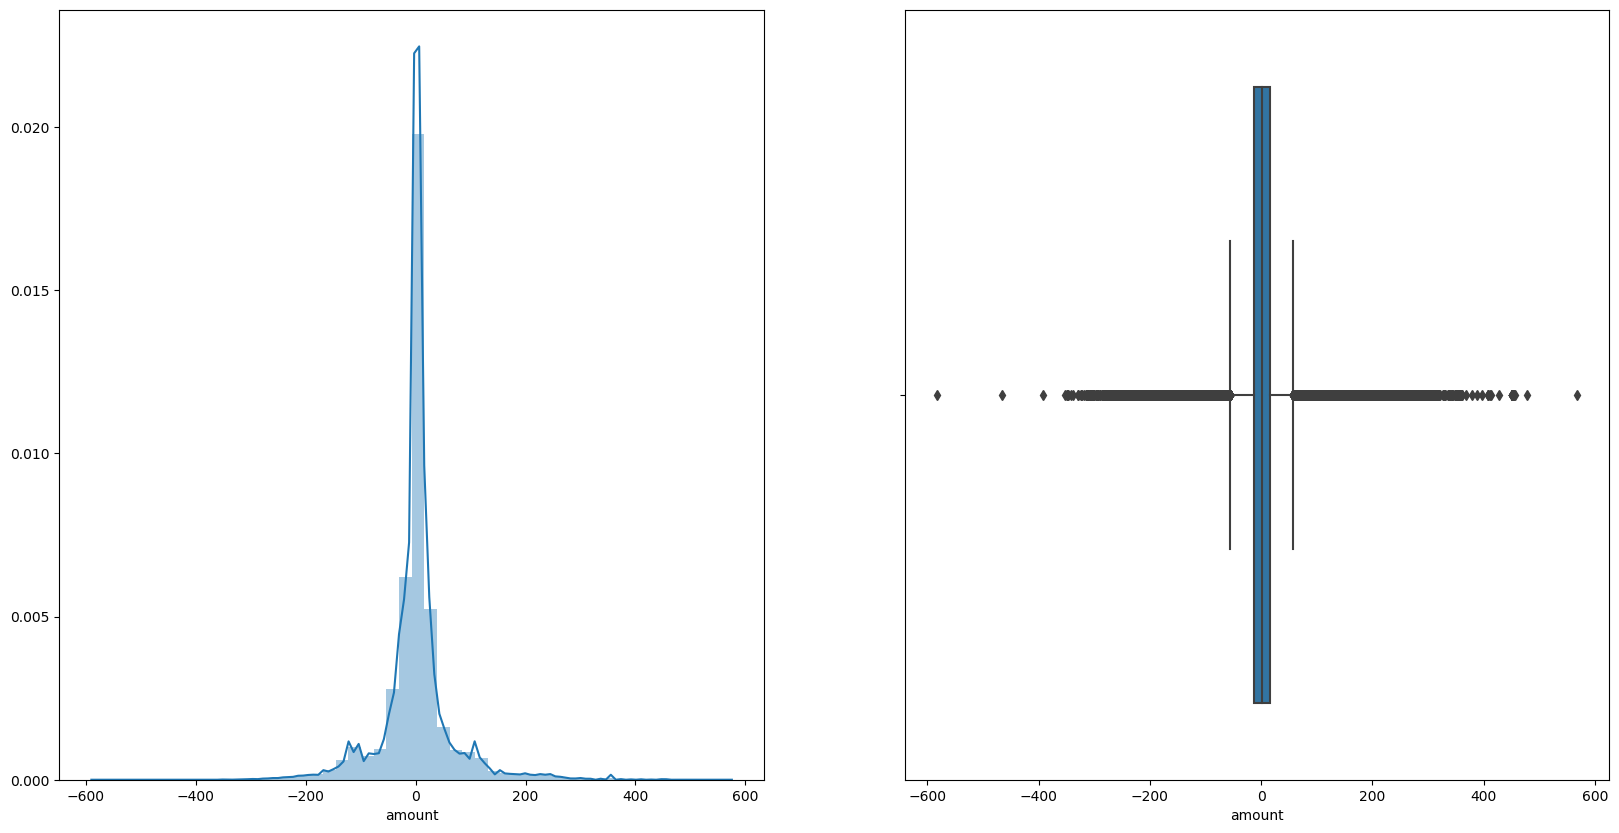

In [59]:
plot_columns(df, 'amount')

In [95]:
# DBSCAN
from sklearn.cluster import DBSCAN
from itertools import product
# Because DBSCAN creates clusters itself based on those two parameters let's check the number of generated clusters.
from sklearn.metrics import silhouette_score


def best_parameters(data, eps_values, min_samples):
    no_of_clusters = []
    sil_score = []
    params = list(product(eps_values, min_samples))
    
    # Iterate over list os params and get score
    for p in params:
        DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data)
        print("- params:", p)
        no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
        sil_score.append(silhouette_score(data, DBS_clustering.labels_))
    
    ### Chart Number of Clusters
    # A heatplot below shows how many clusters were generated by the DBSCAN algorithm for the respective parameters combinations.
    tmp = pd.DataFrame.from_records(params, columns =['Eps', 'Min_samples'])   
    tmp['No_of_clusters'] = no_of_clusters

    pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
    ax.set_title('Number of clusters')
    plt.show()
    
    ### Chart Silhoutte Score
    # To decide which combination to choose I will use a metric - a silhuette score and I will plot it as a heatmap again.
    tmp = pd.DataFrame.from_records(params, columns =['Eps', 'Min_samples'])   
    tmp['Sil_score'] = sil_score

    pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
    ax.set_title('Silhoutte scores')
    plt.show()
    
    print("Best silhoutte score:")
    best_row = tmp['Sil_score'].idxmax()
    print("Row:", best_row)
    best_params = tmp.loc[best_row]
    print("Values:")
    print(best_params)
    
    return best_params


def calc_cluster(data, params):
    # Best dbscan cluster combination 
    DBS_clustering = DBSCAN(eps=best_comb['Eps'], min_samples=best_comb['Min_samples']).fit(data)
    DBSCAN_clustered = data.copy()
    DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points
    return DBSCAN_clustered
    
    
def results(cluster): 
    # Checking sizes of clusters
    DBSCAN_clust_sizes = cluster.groupby('Cluster').size().to_frame()
    DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
    # get outliers list
    outliers = cluster[cluster['Cluster']==-1]       
    return {'clust_sizes': DBSCAN_clust_sizes, 'outliers': outliers}

# fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

# plt.scatter('count', 'price',
#                 data=dbscan_cluster[dbscan_cluster['Cluster']!=-1],
#                 #hue='Cluster', 
#             #ax=axes[0], 
#             #palette='Set1', 
#             #legend='full',
#             s=45)

# plt.scatter('amount', 'price',
#                 data=dbscan_cluster[dbscan_cluster['Cluster']!=-1],
#             #    hue='Cluster', 
#             #palette='Set1', 
#             #ax=axes[1],
#             # legend='full',
#             s=45)

# axes[0].scatter(results['outliers']['count'], results['outliers']['price'], s=5, label='outliers', c="k")
# axes[1].scatter(results['outliers']['amount'], results['outliers']['price'], s=5, label='outliers', c="k")
# axes[0].legend()
# axes[1].legend()

# plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
# plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

# plt.show()


In [71]:
# It is difficult arbitrarily to say what values will work the best. Therefore, I will first create a matrix of investigated combinations.
eps_values = np.arange(8,12,0.5) # eps values to be investigated
min_samples = np.arange(4,8) # min_samples values to be investigated

- params: (8.0, 4)
- params: (8.0, 5)
- params: (8.0, 6)
- params: (8.0, 7)
- params: (8.5, 4)
- params: (8.5, 5)
- params: (8.5, 6)
- params: (8.5, 7)
- params: (9.0, 4)
- params: (9.0, 5)
- params: (9.0, 6)
- params: (9.0, 7)
- params: (9.5, 4)
- params: (9.5, 5)
- params: (9.5, 6)
- params: (9.5, 7)
- params: (10.0, 4)
- params: (10.0, 5)
- params: (10.0, 6)
- params: (10.0, 7)
- params: (10.5, 4)
- params: (10.5, 5)
- params: (10.5, 6)
- params: (10.5, 7)
- params: (11.0, 4)
- params: (11.0, 5)
- params: (11.0, 6)
- params: (11.0, 7)
- params: (11.5, 4)
- params: (11.5, 5)
- params: (11.5, 6)
- params: (11.5, 7)


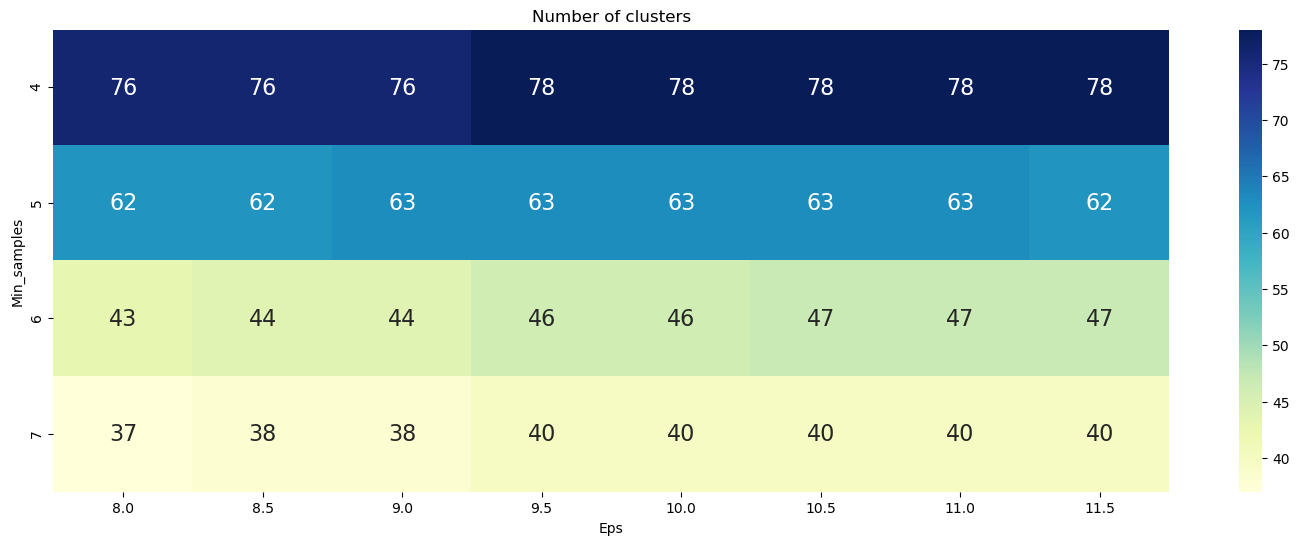

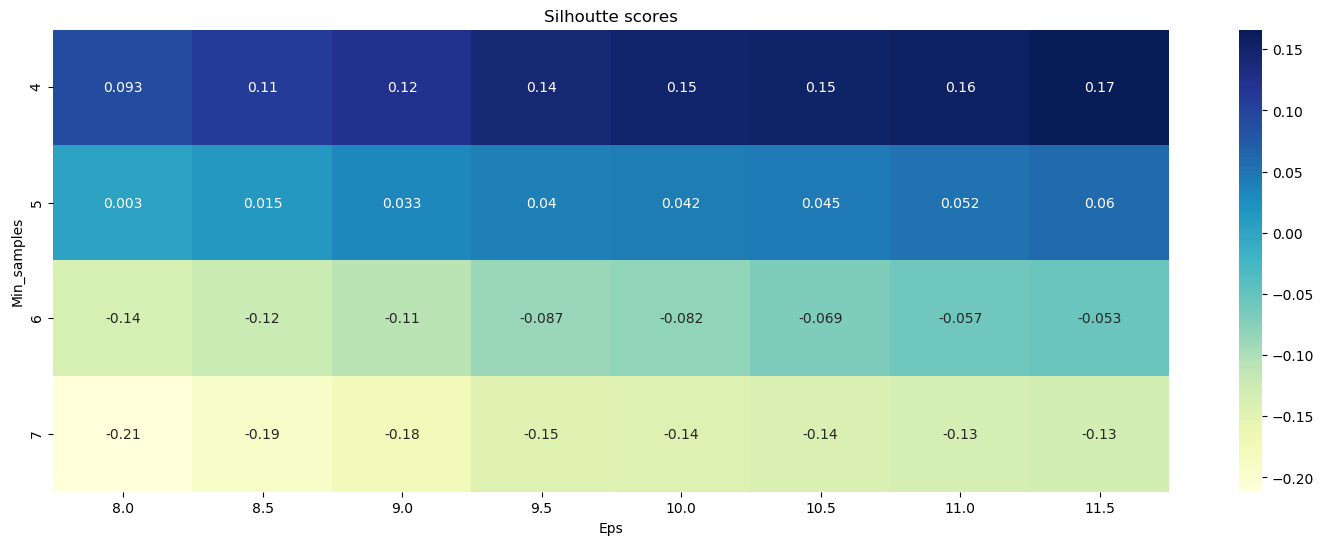

Best silhoutte score:
Row: 28
Values:
Eps            11.500000
Min_samples     4.000000
Sil_score       0.166001
Name: 28, dtype: float64


In [72]:
# subset with numeric variables only
X_numerics = df[:1000]

# get best parameter combination
params = best_parameters(X_numerics, eps_values, min_samples)    
# dbscan fitted model
dbscan_cluster = calc_cluster(X_numerics, params)
# dbbscan cluster results
results = results(dbscan_cluster)

In [68]:
results['clust_sizes']

,DBSCAN_size
Cluster,
-1,418
0,8
1,13
2,17
3,17
...,...
72,5
73,5
74,4


In [69]:
results['outliers']

,price,count,amount,Cluster
0,29700.0,66.0,35.28890,-1
1,29600.0,89.0,165.05500,-1
2,29500.0,38.0,112.13500,-1
14,28300.0,68.0,3.14403,-1
15,28200.0,69.0,17.92200,-1
...,...,...,...,...
3441,25600.0,37.0,4.24183,-1
3442,25500.0,64.0,5.22004,-1
3443,25400.0,31.0,1.82050,-1
3445,25200.0,42.0,3.81912,-1


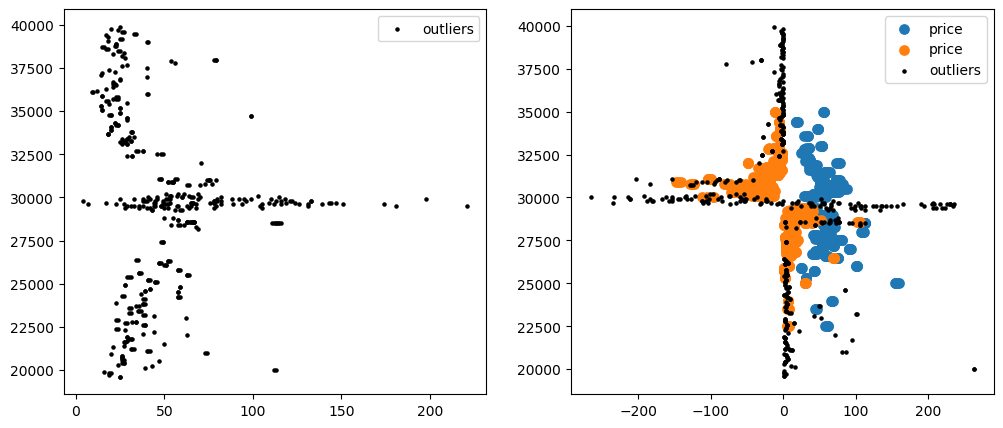

In [73]:
fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

plt.scatter('count', 'price',
                data=dbscan_cluster[dbscan_cluster['Cluster']!=-1],
                #hue='Cluster', 
            #ax=axes[0], 
            #palette='Set1', 
            #legend='full',
            s=45)

plt.scatter('amount', 'price',
                data=dbscan_cluster[dbscan_cluster['Cluster']!=-1],
            #    hue='Cluster', 
            #palette='Set1', 
            #ax=axes[1],
            # legend='full',
            s=45)

axes[0].scatter(results['outliers']['count'], results['outliers']['price'], s=5, label='outliers', c="k")
axes[1].scatter(results['outliers']['amount'], results['outliers']['price'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

## 2 - Mean dataset per date/hour

In [74]:
df_mean = df_or.drop(columns=['Unnamed: 0', 'type'], axis=1)
df_mean

,time,price,count,amount
0,2022-05-25 13,29700.0,66.0,35.288900
1,2022-05-25 13,29600.0,89.0,165.055000
2,2022-05-25 13,29500.0,38.0,112.135000
3,2022-05-25 13,29400.0,46.0,38.608200
4,2022-05-25 13,29300.0,39.0,20.189200
...,...,...,...,...
170395,2022-06-29 23,29700.0,14.0,-0.094611
170396,2022-06-29 23,29800.0,18.0,-10.528400
170397,2022-06-29 23,29900.0,22.0,-0.282586
170398,2022-06-29 23,30000.0,45.0,-2.248110


In [75]:
df_mean[df_mean['time'] == '2022-06-29 23']

,time,price,count,amount
170200,2022-06-29 23,20100.0,94.0,38.181400
170201,2022-06-29 23,20000.0,154.0,219.103000
170202,2022-06-29 23,19900.0,83.0,217.088000
170203,2022-06-29 23,19800.0,105.0,53.266100
170204,2022-06-29 23,19700.0,115.0,48.367900
...,...,...,...,...
170395,2022-06-29 23,29700.0,14.0,-0.094611
170396,2022-06-29 23,29800.0,18.0,-10.528400
170397,2022-06-29 23,29900.0,22.0,-0.282586
170398,2022-06-29 23,30000.0,45.0,-2.248110


In [76]:
df_mean = df_mean.groupby('time').mean()
df_mean.reset_index(drop=True)

,price,count,amount
0,29700.000000,41.702500,2.443115
1,29716.666667,41.751667,2.569361
2,29750.000000,41.820000,2.257616
3,29550.000000,41.940000,2.610268
4,29550.000000,42.160000,2.343295
...,...,...,...
841,20050.000000,46.690000,4.876145
842,20350.000000,45.355000,4.575663
843,20250.000000,44.930000,4.846802
844,20250.000000,45.630000,4.492094


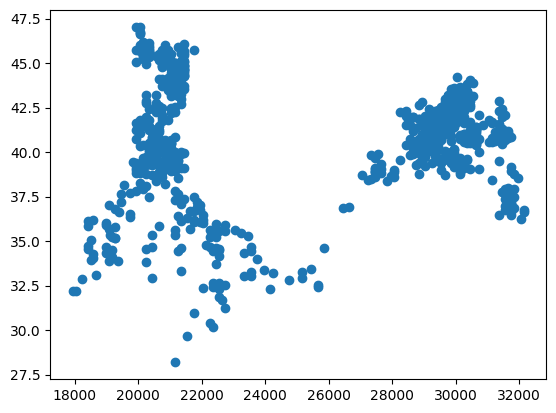

In [77]:
plt.scatter(x=df_mean['price'], y=df_mean['count'])
plt.show()

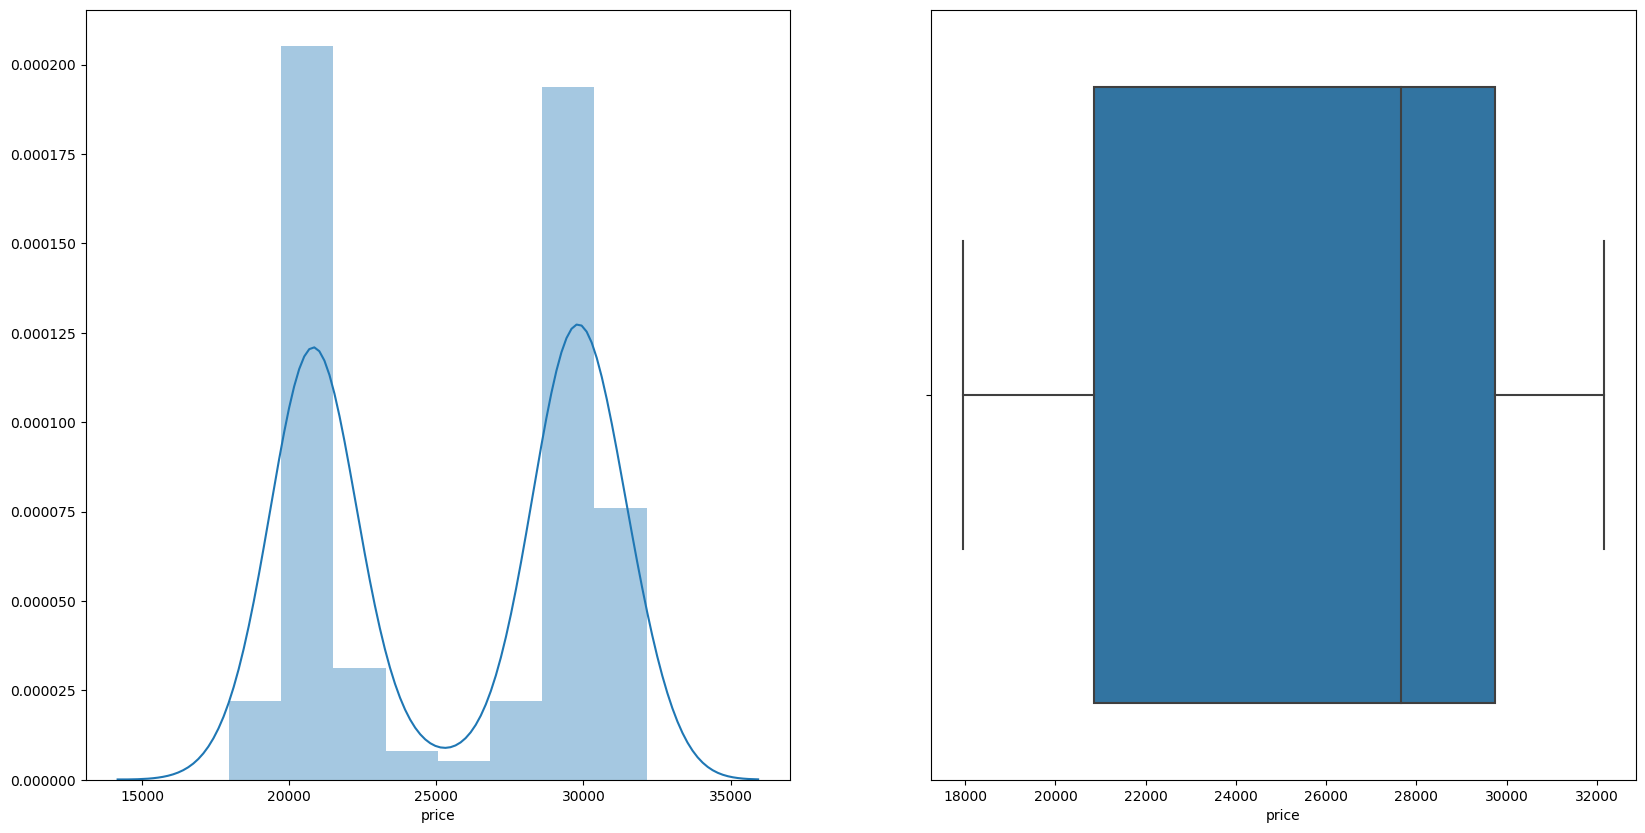

In [78]:
plot_columns(df_mean, 'price')

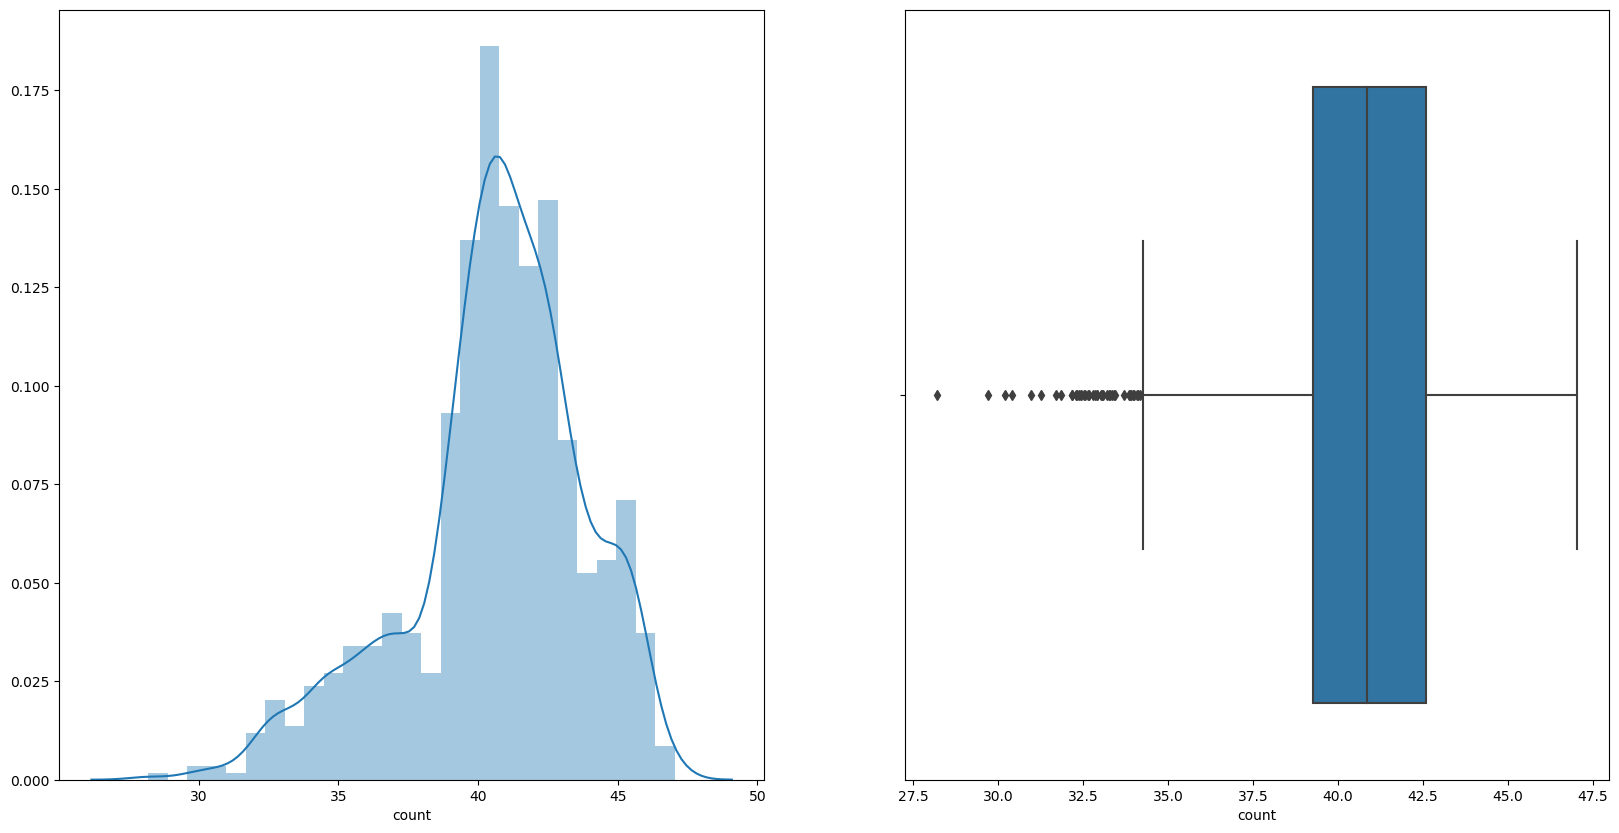

In [79]:
plot_columns(df_mean, 'count')

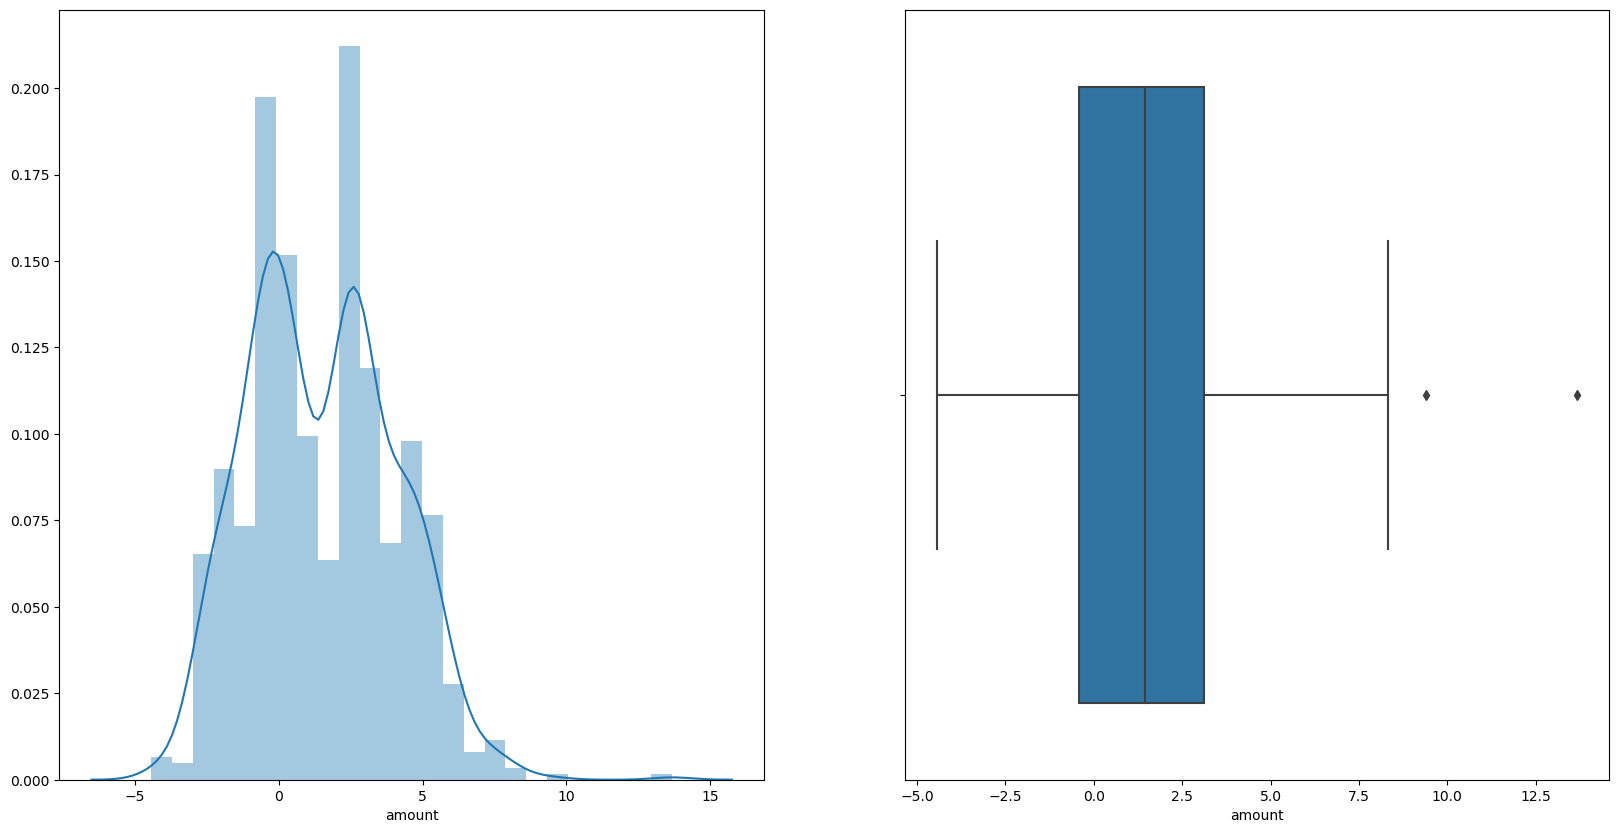

In [80]:
plot_columns(df_mean, 'amount')

### 2.1 - Outlier Detection

- params: (8.0, 4)
- params: (8.0, 5)
- params: (8.0, 6)
- params: (8.0, 7)
- params: (8.5, 4)
- params: (8.5, 5)
- params: (8.5, 6)
- params: (8.5, 7)
- params: (9.0, 4)
- params: (9.0, 5)
- params: (9.0, 6)
- params: (9.0, 7)
- params: (9.5, 4)
- params: (9.5, 5)
- params: (9.5, 6)
- params: (9.5, 7)
- params: (10.0, 4)
- params: (10.0, 5)
- params: (10.0, 6)
- params: (10.0, 7)
- params: (10.5, 4)
- params: (10.5, 5)
- params: (10.5, 6)
- params: (10.5, 7)
- params: (11.0, 4)
- params: (11.0, 5)
- params: (11.0, 6)
- params: (11.0, 7)
- params: (11.5, 4)
- params: (11.5, 5)
- params: (11.5, 6)
- params: (11.5, 7)


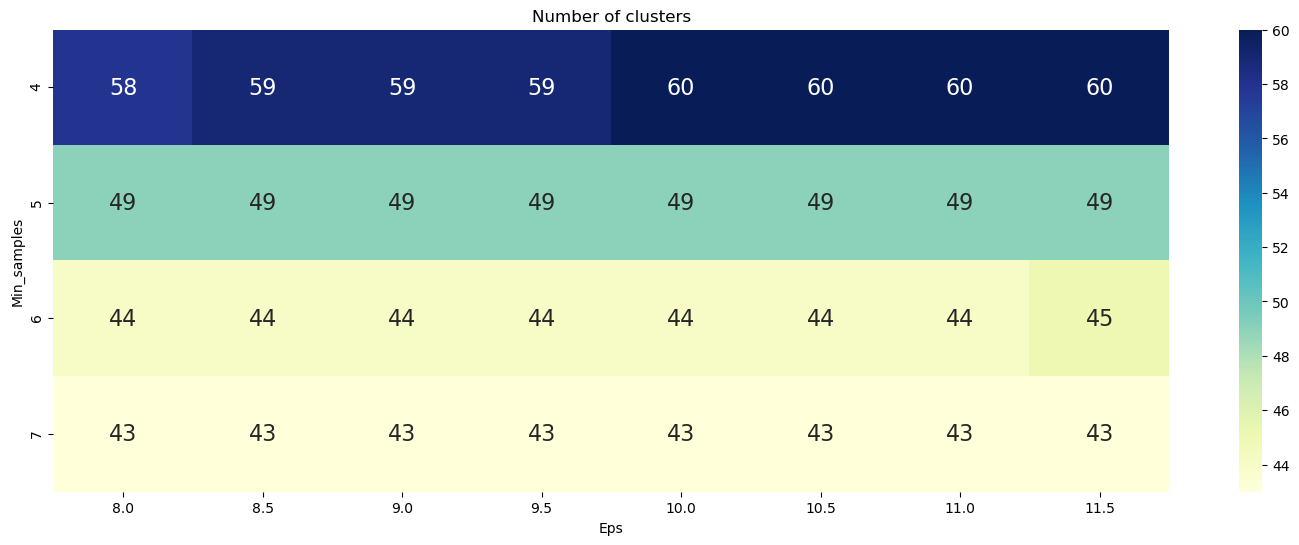

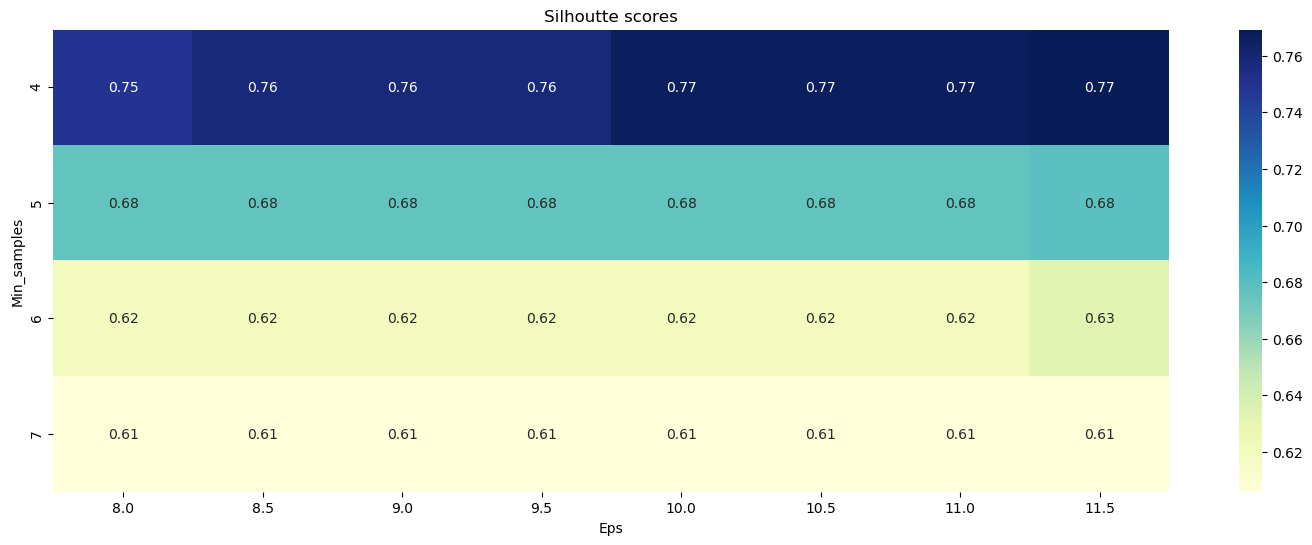

Best silhoutte score:
Row: 28
Values:
Eps            11.500000
Min_samples     4.000000
Sil_score       0.769151
Name: 28, dtype: float64


In [87]:
# get best parameter combination
params1 = best_parameters(df_mean, eps_values, min_samples)   

In [91]:
# dbscan fitted model
dbscan_cluster1 = calc_cluster(df_mean, params1)
dbscan_cluster1

,price,count,amount,Cluster
time,,,,
2022-05-25 13,29700.000000,41.702500,2.443115,-1
2022-05-25 14,29716.666667,41.751667,2.569361,-1
2022-05-25 15,29750.000000,41.820000,2.257616,0
2022-05-25 16,29550.000000,41.940000,2.610268,1
2022-05-25 17,29550.000000,42.160000,2.343295,1
...,...,...,...,...
2022-06-29 19,20050.000000,46.690000,4.876145,58
2022-06-29 20,20350.000000,45.355000,4.575663,51
2022-06-29 21,20250.000000,44.930000,4.846802,44


In [96]:
# dbbscan cluster results
results1 = results(dbscan_cluster1)

In [97]:
results1['clust_sizes']

,DBSCAN_size
Cluster,
-1,91
0,34
1,23
2,17
3,14
4,22
5,13
6,13
7,18


In [98]:
results1['outliers']

,price,count,amount,Cluster
time,,,,
2022-05-25 13,29700.000000,41.702500,2.443115,-1
2022-05-25 14,29716.666667,41.751667,2.569361,-1
2022-05-26 09,29200.000000,41.920000,2.191919,-1
2022-05-27 09,29000.000000,39.767500,2.474041,-1
2022-05-27 18,28250.000000,39.585000,2.756618,-1
...,...,...,...,...
2022-06-19 17,19456.650000,37.645000,-0.817111,-1
2022-06-19 18,19554.450000,38.170000,-0.413455,-1
2022-06-20 18,19850.450000,39.460000,-1.433936,-1


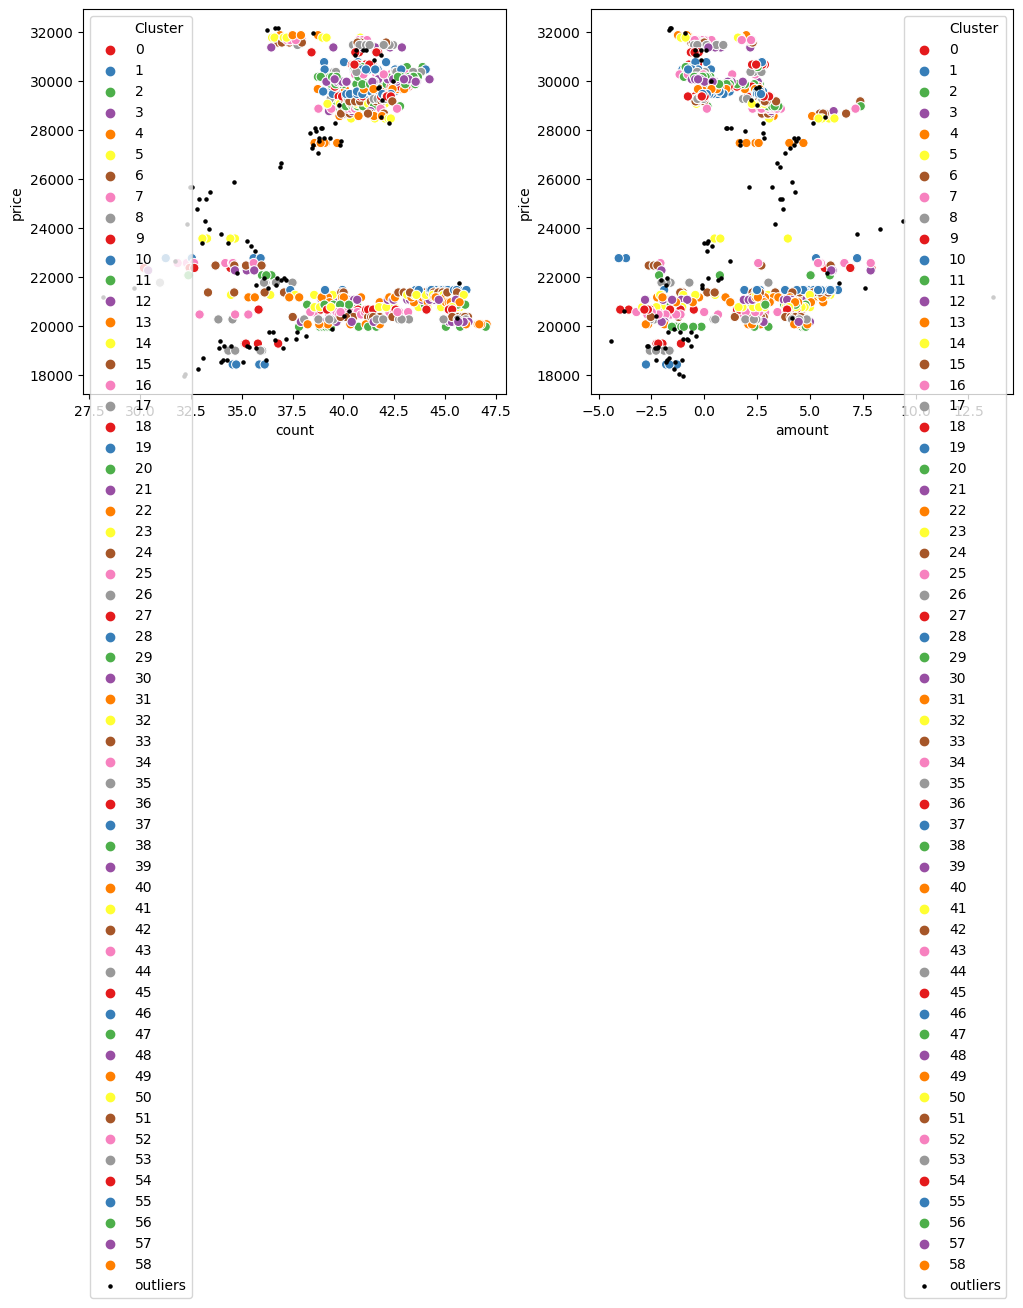

In [101]:
fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('count', 'price',
                data=dbscan_cluster1[dbscan_cluster1['Cluster']!=-1],
                hue='Cluster', 
            ax=axes[0], 
            palette='Set1', 
            legend='full',
            s=45)

sns.scatterplot('amount', 'price',
                data=dbscan_cluster1[dbscan_cluster1['Cluster']!=-1],
               hue='Cluster', 
            palette='Set1', 
            ax=axes[1],
            legend='full',
            s=45)

axes[0].scatter(results1['outliers']['count'], results1['outliers']['price'], s=5, label='outliers', c="k")
axes[1].scatter(results1['outliers']['amount'], results1['outliers']['price'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()